## Submission instructions

All code that you write should be in this notebook. Please include your names and student numbers. You have to submit two files:

* This notebook with your code added. Make sure to add enough documentation.
* A short report, around 2 pages including any figures and/or tables (it is likely that you won't need the full 2 pages). Use [this template](https://www.overleaf.com/read/mvskntycrckw).

For questions, make use of the "Lab" session (see schedule).
Questions can also be posted to the MS teams channel called "Lab".

**Note:** You are free to make use of Python libraries (e.g., numpy, sklearn, etc.) except any *fairness* libraries.

#### Name and student numbers
...


## Dataset

In this assignment we are going to use the **COMPAS** dataset.

If you haven't done so already, take a look at this article: https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing.
For background on the dataset, see https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm.

**Reading in the COMPAS dataset**

The dataset can be downloaded here: https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv

For this assignment, we focus on the protected attribute *race*.

The label (the variable we want to be able to predict) represents recidivism, which is defined as a new arrest within 2 years.

In [1]:
# !wget -c https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import random

def set_seed(seed):
    #set all random seeds
    np.random.seed(seed)
    random.seed(seed)
    return None

SEED = 42

set_seed(SEED)
compas_data = pd.read_csv('compas-scores-two-years.csv')

We apply several data preprocessing steps, including only retaining Caucasians and African Americans.

In [3]:
compas_data = compas_data[(compas_data.days_b_screening_arrest <= 30)
            & (compas_data.days_b_screening_arrest >= -30)
            & (compas_data.is_recid != -1)
            & (compas_data.c_charge_degree != 'O')
            & (compas_data.score_text != 'N/A')
            & ((compas_data.race == 'Caucasian') | (compas_data.race == 'African-American'))]

Take a look at the data:

In [4]:
compas_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0


Now take a look at the distribution of the protected attribute `race` and the distribution of our outcome variable `two_year_recid`.

**Note:** in the context of fair machine learning, the favorable label here is no recidivism, i.e., ```two_year_recid = 0```

In [5]:
print('Number of instances per race category:')
print(compas_data[['race', 'two_year_recid']].value_counts())

Number of instances per race category:
race              two_year_recid
African-American  1                 1661
                  0                 1514
Caucasian         0                 1281
                  1                  822
Name: count, dtype: int64


## Data analysis

### **1. Exploration**

Perform an exploratory analysis of your data and describe the results in your report.
Include at least the following:

1. The size of your data;
2. The size of the protected attribute classes;
3. The base rates (the probability of a favorable outcome for the two protected attribute classes);
4. The base rates for the combination of both race and sex categories. What do you see?

In [6]:
data_size = len(compas_data)

print("Data Size:", data_size)

vals = dict(compas_data[['race']].value_counts())
svals = dict(compas_data[['sex']].value_counts())

labels = ["Race","Sex","Recidivism"]
rows=[]

bb_rate = compas_data.loc[(compas_data['two_year_recid']==0)].shape[0]
bb_frac = bb_rate/data_size
rows.append(['*All Races','*All Sexes',bb_frac])

for sval,num in svals.items():
    recid2 = compas_data.loc[(compas_data['sex']==sval[0]) &(compas_data['two_year_recid']==0)].shape[0]
    snum2 = compas_data.loc[(compas_data['sex']==sval[0])].shape[0]
    frac = str(recid2/snum2)
    rows.append(['*All Races',sval[0],frac])
        
    
for val,num in vals.items():
    #print(val,num)
    recid = compas_data.loc[(compas_data['race']==val[0]) & (compas_data['two_year_recid']==0)].shape[0]
    #rint(recid)
    frac = str(recid/num)
    print("Size of class ", val[0],":",num)
    print(f'Base rate {val[0]}: {frac}')
    rows.append([val[0],"*All Sexes",frac])
    for sval,_ in svals.items():
        #Combined Sex and Race
        recid = compas_data.loc[(compas_data['race']==val[0]) & (compas_data['sex']==sval[0]) &(compas_data['two_year_recid']==0)].shape[0]
        snum = compas_data.loc[(compas_data['race']==val[0]) & (compas_data['sex']==sval[0])].shape[0]
        frac = str(recid/snum)
        print(f'Base rate {val[0]} ({sval[0]}): {frac}')
        rows.append([val[0],sval[0],frac])

Data Size: 5278
Size of class  African-American : 3175
Base rate African-American: 0.4768503937007874
Base rate African-American (Male): 0.44478293983244477
Base rate African-American (Female): 0.6302367941712204
Size of class  Caucasian : 2103
Base rate Caucasian: 0.609129814550642
Base rate Caucasian (Male): 0.5977791486736582
Base rate Caucasian (Female): 0.6473029045643154


Sex               *All Sexes    Female      Male
Race                                            
*All Races          0.529557  0.638215  0.503179
African-American    0.476850  0.630237  0.444783
Caucasian           0.609130  0.647303  0.597779
Sex               *All Sexes    Female      Male
Race                                            
*All Races          0.529557  0.638215  0.503179
African-American    0.476850  0.630237  0.444783
Caucasian           0.609130  0.647303  0.597779


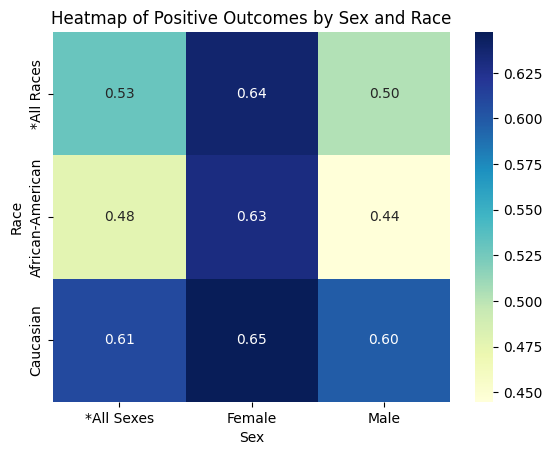

In [7]:
import matplotlib.pyplot as plt
df = pd.DataFrame(rows,columns=labels)
df['Recidivism'] = pd.to_numeric(df['Recidivism'])

df=df.pivot(index="Race",columns="Sex",values="Recidivism")
print(df)
# replace the Month with year 
df = df.rename(columns={"Race":"Sex"})
# drop first column
#df = df.iloc[0:].reset_index(drop=True)

print(df)
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt='.2f')

plt.title('Heatmap of Positive Outcomes by Sex and Race')
plt.show()

### **2. Performance measures**

You will have to measure the performance and fairness of different classifiers in question 5. The performance will be calculated with the precision, recall, F1 and accuracy.
Additionally, you will have to calculate the statistical/demographic parity, the true positive rate (recall) and false positive rate per race group.

Make sure that you are able to calculate these metrics in the cell below.

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def generalized_metrics(df, group_column='race', prediction_column='prediction', disparity_threshold=0.8, baseline_group=None):
    '''
    df: pandas DataFrame, must contain columns 'two_year_recid', 'prediction' and the column specified in 'group_column' (default "race")
    group_column: the column used to define groups for fairness analysis
    prediction_column: the column containing model predictions
    disparity_threshold: threshold used to determine if disparity exists in fairness metrics
    baseline_group: specific group to use as baseline for comparisons; if not provided or not found, defaults to the first group
    
    returns: dictionary with performance and fairness metrics
    '''
    performance = {}
    unique_groups = df[group_column].unique()
    
    # Basic model performance metrics
    performance['accuracy'] = accuracy_score(df['two_year_recid'], df[prediction_column])
    precision, recall, f1, _ = precision_recall_fscore_support(df['two_year_recid'], df[prediction_column], average='binary')
    performance['precision'] = precision
    performance['recall'] = recall
    performance['f1'] = f1
    
    # here're dicts for group-specific metrics
    positive_rate, true_positive_rate, false_positive_rate = {}, {}, {}
    
    for group in unique_groups:
        group_df = df[df[group_column] == group]
        # Positive rate
        positive_rate[group] = group_df[group_df[prediction_column] == 0].shape[0] / max(group_df.shape[0], 1e-6)
        # True positive rate (TPR)
        true_positive_rate[group] = group_df[(group_df[prediction_column] == 0) & (group_df['two_year_recid'] == 0)].shape[0] / max(group_df[group_df['two_year_recid'] == 0].shape[0], 1e-6)
        # False positive rate (FPR)
        false_positive_rate[group] = group_df[(group_df[prediction_column] == 0) & (group_df['two_year_recid'] == 1)].shape[0] / max(group_df[group_df['two_year_recid'] == 1].shape[0], 1e-6)
        
        # Store TPR and FPR for each group
        performance[f'{group}_true_positive_rate'] = true_positive_rate[group]
        performance[f'{group}_false_positive_rate'] = false_positive_rate[group]
    
    # Ensure baseline group is valid
    if baseline_group not in unique_groups:
        baseline_group = unique_groups[0]
    
    # Compute fairness metrics against baseline group
    for group in unique_groups:
        if group != baseline_group:
            performance[f'{group}_vs_{baseline_group}_disparate_impact'] = positive_rate[group] / max(positive_rate[baseline_group], 1e-8)
            performance[f'{group}_vs_{baseline_group}_demographic_parity'] = (positive_rate[group] / max(positive_rate[baseline_group], 1e-8)) > disparity_threshold
            performance[f'{group}_vs_{baseline_group}_equal_opportunity'] = (true_positive_rate[group] / max(true_positive_rate[baseline_group], 1e-8)) > disparity_threshold
            performance[f'{group}_vs_{baseline_group}_predictive_parity'] = (false_positive_rate[group] / max(false_positive_rate[baseline_group], 1e-8)) > disparity_threshold

    # Round all metrics to 4 decimal places
    for key in performance.keys():
        performance[key] = round(performance[key], 4)

    return performance


In [9]:
# example usage
compas_data['prediction'] = np.random.randint(0, 2, compas_data.shape[0])

generalized_metrics(compas_data, group_column='race', baseline_group='Caucasian')

{'accuracy': 0.5064,
 'precision': 0.4768,
 'recall': 0.5046,
 'f1': 0.4903,
 'African-American_true_positive_rate': 0.5099,
 'African-American_false_positive_rate': 0.4937,
 'Caucasian_true_positive_rate': 0.5059,
 'Caucasian_false_positive_rate': 0.4988,
 'African-American_vs_Caucasian_disparate_impact': 0.9967,
 'African-American_vs_Caucasian_demographic_parity': 1,
 'African-American_vs_Caucasian_equal_opportunity': 1,
 'African-American_vs_Caucasian_predictive_parity': 1}

### **3. Prepare the data**
For the classifiers in question 5, the input of the model can only contain numerical values, it is therefore important to convert the strings in the columns (features) of interest of the `compas_data` to floats or integers.

The columns of interest are features that you think will be informative or interesting in predicting the outcome variable.

Use the cell below to explore which of the compas variables you need to convert to be able to use them for the classifiers. Also make sure that you understand the relationship between categorical and numerical values.

Then generate a new dataframe with your selected features in the right encoding (also make sure to include `two_year_recid`). You can implement this yourself, or use the `LabelEncoder` from `sklearn`.

**Note:** you do not need to convert all columns/features, only the ones you are interested in. Please include in your **report** a short motivation (one-two sentence) per feature why you think this is informative or interesting to take into account.

In [10]:
# Your code to prepare the data
# print data type of each column
print('initial dataset dat atypes', compas_data.dtypes)

obj_features = compas_data.select_dtypes(include='object').columns
print('list of non numerical features:', obj_features)

date_time_features = ['dob', 'c_jail_in', 'c_jail_out',
       'c_offense_date', 'c_arrest_date', 'in_custody', 'out_custody']

non_train_features = ['is_recid', 'c_days_from_compas', 'type_of_assessment', 'compas_screening_date', 'days_b_screening_arrest', 'screening_date', 'compas_screening_date', 'priors_count.1', 'start', 'end', 'event', 'decile_score.1', 'decile_score', 'score_text', 'name', 'first', 'last', 'id', 'c_case_number', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
                       'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'v_score_text', 'v_type_of_assessment', 'v_decile_score', 'v_screening_date', 
                       'is_violent_recid', 'violent_recid']

categorical_features = list(set(obj_features) - set(date_time_features) - set(non_train_features))
categorical_features
print('list of categorical features:', categorical_features)

initial dataset dat atypes id                           int64
name                        object
first                       object
last                        object
compas_screening_date       object
sex                         object
dob                         object
age                          int64
age_cat                     object
race                        object
juv_fel_count                int64
decile_score                 int64
juv_misd_count               int64
juv_other_count              int64
priors_count                 int64
days_b_screening_arrest    float64
c_jail_in                   object
c_jail_out                  object
c_case_number               object
c_offense_date              object
c_arrest_date               object
c_days_from_compas         float64
c_charge_degree             object
c_charge_desc               object
is_recid                     int64
r_case_number               object
r_charge_degree             object
r_days_from_arrest         f

In [11]:
def dt_to_seconds(series):
    series = pd.to_datetime(series)
    return (series - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

class FeaturePreprocessor:
    def __init__(self, categorical_features, date_time_features, non_train_features, min_freq=0.01):
        self.categorical_features = categorical_features
        self.date_time_features = date_time_features
        self.non_train_features = non_train_features
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False, min_frequency=min_freq)

    def fit_transform(self, X, full_cetagorical_df):
        X = X.copy()
        X = X.drop(columns=self.non_train_features)
        self.numerical_features = list(set(X.columns) - set(self.categorical_features))
        for ftr in self.date_time_features:
            X[ftr] = dt_to_seconds(X[ftr])
            if X[ftr].isna().sum() > 0:
                new_ftr = ftr + '_missing'
                X[new_ftr] = X[ftr].isna().astype(int)
                X[ftr] = X[ftr].fillna(-1)
        
        X[self.numerical_features] = self.scaler.fit_transform(X[self.numerical_features])
        self.encoder.fit(full_cetagorical_df)
        ohe_feature_names = self.encoder.get_feature_names_out()
        X[ohe_feature_names] = self.encoder.transform(X[self.categorical_features])
        X = X.drop(columns=self.categorical_features)
        for col in ['r_days_from_arrest', 'violent_recid']:
            if col in X.columns:
                X[col] = X[col].fillna(0)
        return X


    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.non_train_features)
        for ftr in self.date_time_features:
            X[ftr] = dt_to_seconds(X[ftr])
            if X[ftr].isna().sum() > 0:
                new_ftr = ftr + '_missing'
                X[new_ftr] = X[ftr].isna().astype(int)
                X[ftr] = X[ftr].fillna(-1)
        
        X[self.numerical_features] = self.scaler.transform(X[self.numerical_features])
        ohe_feature_names = self.encoder.get_feature_names_out()
        X[ohe_feature_names] = self.encoder.transform(X[self.categorical_features])
        X = X.drop(columns=self.categorical_features)
        return X

### **4. Train and test split**

Divide the dataset into a train (80%) and test split (20%), either by implementing it yourself, or by using an existing library.

**Note:** Usually when carrying out machine learning experiments,
we also need a dev set for developing and selecting our models (incl. tuning of hyper-parameters).
However, in this assignment, the goal is not to optimize
the performance of models so we'll only use a train and test split.




In [12]:
X, y = compas_data.drop(columns=['two_year_recid']), compas_data['two_year_recid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [13]:
# non_ohe_ftrs = list(set(X_train.columns) - set(processor.encoder.get_feature_names_out()))
# X_train[non_ohe_ftrs].isna().sum()

In [14]:
processor = FeaturePreprocessor(categorical_features, date_time_features, non_train_features)
X_train = processor.fit_transform(X_train, X[categorical_features])
X_test = processor.transform(X_test)

In [15]:
print('categorcial features:')
for cat in processor.categorical_features:
    print(cat)
print(('\n'))
print('date time features:')
for date in processor.date_time_features:
    print(date)
print(('\n'))
print('numerical features:')
for num in processor.numerical_features:
    print(num)

categorcial features:
age_cat
c_charge_desc
c_charge_degree
sex
race


date time features:
dob
c_jail_in
c_jail_out
c_offense_date
c_arrest_date
in_custody
out_custody


numerical features:
in_custody
juv_misd_count
prediction
juv_fel_count
dob
juv_other_count
c_offense_date
c_jail_in
c_arrest_date
out_custody
age
priors_count
c_jail_out


### **5. Classifiers**

Now, train and test different classifiers and report the following statistics:

* Overall precision, recall, F1 and accuracy;
* The statistical parity difference for the protected attribute (difference between the probability of a favorable label);
* The true positive rates and the false positive rates of the two protected attribute groups.

For training the classifier we recommend using scikit-learn (https://scikit-learn.org/stable/).

#### **5.1 Regular classification**
Train a logistic regression classifier with the race feature and all other features that you are interested in.

In [16]:
logreg = LogisticRegression(random_state=SEED)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
test_res_df = X_test.copy()
test_res_df['race'] = 'African-American'
test_res_df.loc[test_res_df['race_Caucasian'] == 1, 'race'] = 'Caucasian'
test_res_df['two_year_recid'] = y_test

test_res_df['prediction'] = y_pred
res = generalized_metrics(test_res_df, group_column='race', baseline_group='Caucasian')
res

{'accuracy': 0.7206,
 'precision': 0.7289,
 'recall': 0.6452,
 'f1': 0.6845,
 'Caucasian_true_positive_rate': 0.849,
 'Caucasian_false_positive_rate': 0.4167,
 'African-American_true_positive_rate': 0.7397,
 'African-American_false_positive_rate': 0.3232,
 'African-American_vs_Caucasian_disparate_impact': 0.7832,
 'African-American_vs_Caucasian_demographic_parity': 0,
 'African-American_vs_Caucasian_equal_opportunity': 1,
 'African-American_vs_Caucasian_predictive_parity': 0}

In [17]:
print('AA_TPR/CC_TPR ratio:', res['African-American_true_positive_rate']/res['Caucasian_true_positive_rate'])

AA_TPR/CC_TPR ratio: 0.8712603062426385


In [18]:
print('AA_FPR/CC_FPR ratio:', res['African-American_false_positive_rate']/res['Caucasian_false_positive_rate'])

AA_FPR/CC_FPR ratio: 0.7756179505639548


#### **5.2 Without the protected attribute**
Train a logistic regression classifier without the race feature, but with all other features you used in 5.1.


In [19]:
X_train_protected = X_train.drop(['race_African-American', 'race_Caucasian'], axis=1)
X_test_protected = X_test.drop(['race_African-American', 'race_Caucasian'], axis=1)

logreg = LogisticRegression(random_state=SEED)
logreg.fit(X_train_protected, y_train)
y_pred = logreg.predict(X_test_protected)

test_res_df['prediction'] = y_pred
res = generalized_metrics(test_res_df, group_column='race', baseline_group='Caucasian')
res

{'accuracy': 0.7216,
 'precision': 0.7295,
 'recall': 0.6472,
 'f1': 0.6859,
 'Caucasian_true_positive_rate': 0.8327,
 'Caucasian_false_positive_rate': 0.4048,
 'African-American_true_positive_rate': 0.7524,
 'African-American_false_positive_rate': 0.3262,
 'African-American_vs_Caucasian_disparate_impact': 0.8123,
 'African-American_vs_Caucasian_demographic_parity': 1,
 'African-American_vs_Caucasian_equal_opportunity': 1,
 'African-American_vs_Caucasian_predictive_parity': 1}

In [20]:
print('AA_TPR/CC_TPR ratio:', res['African-American_true_positive_rate']/res['Caucasian_true_positive_rate'])

AA_TPR/CC_TPR ratio: 0.9035667107001321


In [21]:
print('AA_FPR/CC_FPR ratio:', res['African-American_false_positive_rate']/res['Caucasian_false_positive_rate'])

AA_FPR/CC_FPR ratio: 0.8058300395256917


#### **5.3 Pre-processing: Reweighing**
Train a classifier with weights (see lecture slides the weight calculation)
* Report the weights that are used for reweighing and a short interpretation/discussion.
* Hint: Think about when you should reweight the data: during initialization or during training (i.e. fit)? Read the documentation of the Logistic regression model in Scikit-learn carefully (if you use it).

In [22]:
data = X_train.copy()
data['outcome'] = y_train

# Calculate the necessary proportions
# Proportions of positive outcomes
P_AA_pos = (data['race_African-American'] == 1) & (data['outcome'] == 0)
P_C_pos = (data['race_Caucasian'] == 1) & (data['outcome'] == 0)

# Proportions of negative outcomes
P_AA_neg = (data['race_African-American'] == 1) & (data['outcome'] == 1)
P_C_neg = (data['race_Caucasian'] == 1) & (data['outcome'] == 1)

# Convert booleans to integers and calculate the proportion
p1_pos = P_AA_pos.sum() / (data['race_African-American'] == 1).sum()
p2_pos = P_C_pos.sum() / (data['race_Caucasian'] == 1).sum()
p1_neg = P_AA_neg.sum() / (data['race_African-American'] == 1).sum()
p2_neg = P_C_neg.sum() / (data['race_Caucasian'] == 1).sum()

# Desired balance for each outcome across all groups
total_pos = data['outcome'].value_counts(normalize=True)[0]  # total proportion of positive outcomes
total_neg = data['outcome'].value_counts(normalize=True)[1]  # total proportion of negative outcomes

# Calculate weights
data['weight'] = np.where(data['race_African-American'] == 1,
                          np.where(data['outcome'] == 0, (total_pos / p1_pos), (total_neg / p1_neg)),
                          np.where(data['outcome'] == 0, (total_pos / p2_pos), (total_neg / p2_neg)))

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train, sample_weight=data['weight'])

LogisticRegression()

In [24]:
y_pred = logreg.predict(X_test)

test_res_df['prediction'] = y_pred
res = generalized_metrics(test_res_df, group_column='race', baseline_group='Caucasian')
res

{'accuracy': 0.7273,
 'precision': 0.7364,
 'recall': 0.6532,
 'f1': 0.6923,
 'Caucasian_true_positive_rate': 0.7673,
 'Caucasian_false_positive_rate': 0.3452,
 'African-American_true_positive_rate': 0.8127,
 'African-American_false_positive_rate': 0.3476,
 'African-American_vs_Caucasian_disparate_impact': 0.9661,
 'African-American_vs_Caucasian_demographic_parity': 1,
 'African-American_vs_Caucasian_equal_opportunity': 1,
 'African-American_vs_Caucasian_predictive_parity': 1}

In [25]:
print('AA_TPR/CC_TPR ratio:', res['African-American_true_positive_rate']/res['Caucasian_true_positive_rate'])

AA_TPR/CC_TPR ratio: 1.0591685129675485


In [26]:
print('AA_FPR/CC_FPR ratio:', res['African-American_false_positive_rate']/res['Caucasian_false_positive_rate'])

AA_FPR/CC_FPR ratio: 1.006952491309386


#### **5.4 Post-processing: Equalized odds**
Use the predictions by the first classifier for this post processing part (see lecture slides for more information about post processing for equalized odds).

Normally, the best parameters `p_00, p_01, p_10, p_11` are found with a linear program that minimizes loss between predictions of a derived predictor and the actual labels. In this assignment we will not ask you to do this. Instead, we would like you to follow the next steps to find parameters, post-process the data and check the performance of this classifier with post-processing:

1. Generate a 1000 different samples of these 4 parameters randomly;
2. Write a function (or more) that applies these 4 parameters to postprocess the predictions.
3. For each generated set of 4 parameters:
  - Change the predicted labels with the function(s) from step 2;
  - Calculate the TPR ratio and FPR ratio over these 'new' predictions;
4. Which set of parameters satisfies the equalized odds fairness measure the best?
5. Check the overall performance (precision, recall, accuracy, etc.) of the new predictions after post-processing and add an interpretation of the results and the parameters in your **report**.

In [27]:
# Your code for step 1


In [28]:
# Your code for step 2


In [29]:
# Your code for step 3


In [30]:
# Your code for step 4 and 5


#### **Results**
For each classifier write in the **report**:
- Whether this classifier satisfies statistical parity and whether this compares to the original dataset;
- Does the classifier satisfy the equal opportunity criterion?
- How do the different classifiers compare against each other?

### **6. Intersectional fairness**
In the questions above `race` was the only protected attribute. However, multiple protected attributes sometimes interact, leading to different fairness outcomes for different combinations of these protected attributes.

Please explore the intersectional fairness for protected attributes `race` and `sex` for the first two classifiers from question 5: instead of only reporting the statistical parity, TPR and FPR for the protected attribute race, make a combination of the `race` and `sex` column, with four categories of this combined protected attribute, and report the maximum difference between the subgroups for statistical parity, TPR and FPR. 
For example, suppose we have four groups with TPRs 0.1, 0.2, 0.8, then the maximum difference is 0.7.
- For classifier 1: evaluate the predictions for this combined protected attribute;
- For classifier 2: remove both `race` and `sex` from the data and check the results again.

Write a short interpretation of these results in your **report**.

In [31]:
prev_race_sex_cols = ['sex_Female', 'sex_Male', 'race_African-American', 'race_Caucasian']

def get_intersect(df):
    intersecting_col = []
    for col in np.array(df[prev_race_sex_cols]):
        if col[0] == 1 and col[2] == 1:
            intersecting_col.append('female_african_american')
        elif col[0] == 1 and col[3] == 1:
            intersecting_col.append('female_caucasian')
        elif col[1] == 1 and col[2] == 1:
            intersecting_col.append('male_african_american')
        elif col[1] == 1 and col[3] == 1:
            intersecting_col.append('male_caucasian')
        elif col[2] == 1:
            intersecting_col.append('unk_african_american')
        elif col[3] == 1:
            intersecting_col.append('unk_caucasian')
        elif col[0] == 1:
            intersecting_col.append('female_unk')
        elif col[1] == 1:
            intersecting_col.append('male_unk')
        else:
            intersecting_col.append('unk_unk')
    return intersecting_col

X_train_intersected = X_train.copy()
X_train_intersected['sex_race'] = get_intersect(X_train_intersected)

X_test_intersected = X_test.copy()
X_test_intersected['sex_race'] = get_intersect(X_test_intersected)

X_train_intersected = X_train_intersected.drop(columns=prev_race_sex_cols)
X_test_intersected = X_test_intersected.drop(columns=prev_race_sex_cols)

ohe_sex_race = OneHotEncoder(sparse_output=False)
ohe_sex_race.fit(X_train_intersected[['sex_race']])
ohe_names = ohe_sex_race.get_feature_names_out()

X_train_intersected[ohe_names] = ohe_sex_race.transform(X_train_intersected[['sex_race']])
X_test_intersected[ohe_names] = ohe_sex_race.transform(X_test_intersected[['sex_race']])

X_train_intersected = X_train_intersected.drop(columns=['sex_race'])
X_test_intersected = X_test_intersected.drop(columns=['sex_race'])

In [32]:
# summarise the number of 1 columns
X_test_intersected[ohe_names].sum()

sex_race_female_african_american    126.0
sex_race_female_caucasian            98.0
sex_race_male_african_american      517.0
sex_race_male_caucasian             315.0
dtype: float64

### sex+race unprotected 

In [39]:
logreg = LogisticRegression(random_state=SEED)
logreg.fit(X_train_intersected, y_train)
y_pred = logreg.predict(X_test_intersected)
test_res_df['sex_race'] = get_intersect(X_test)
test_res_df['two_year_recid'] = y_test

test_res_df['prediction'] = y_pred
res = generalized_metrics(test_res_df, group_column='sex_race', baseline_group='female_african_american')
res

{'accuracy': 0.7206,
 'precision': 0.7289,
 'recall': 0.6452,
 'f1': 0.6845,
 'female_caucasian_true_positive_rate': 0.8594,
 'female_caucasian_false_positive_rate': 0.5294,
 'male_african_american_true_positive_rate': 0.6609,
 'male_african_american_false_positive_rate': 0.2852,
 'female_african_american_true_positive_rate': 0.9634,
 'female_african_american_false_positive_rate': 0.5455,
 'male_caucasian_true_positive_rate': 0.8453,
 'male_caucasian_false_positive_rate': 0.3955,
 'female_caucasian_vs_female_african_american_disparate_impact': 0.9112,
 'female_caucasian_vs_female_african_american_demographic_parity': 1,
 'female_caucasian_vs_female_african_american_equal_opportunity': 1,
 'female_caucasian_vs_female_african_american_predictive_parity': 1,
 'male_african_american_vs_female_african_american_disparate_impact': 0.556,
 'male_african_american_vs_female_african_american_demographic_parity': 0,
 'male_african_american_vs_female_african_american_equal_opportunity': 0,
 'male_a

In [38]:
print('CC_fem_TPR/AA_fem_TPR ratio:', res['female_caucasian_true_positive_rate']/res['female_african_american_true_positive_rate'])
print('CC_fem_TPR/AA_fem_FPR ratio:', res['female_caucasian_false_positive_rate']/res['female_african_american_false_positive_rate'])

# print same statistic for all other groups: male_african_american, female_african_american
print('\n')

print('CC_m_TPR/AA_fem_TPR ratio:', res['male_caucasian_true_positive_rate']/res['female_african_american_true_positive_rate'])
print('CC_m_TPR/AA_fem_FPR ratio:', res['male_caucasian_false_positive_rate']/res['female_african_american_false_positive_rate'])

print('\n')

print('AA_m_TPR/AA_fem_TPR ratio:', res['male_african_american_true_positive_rate']/res['female_african_american_true_positive_rate'])
print('AA_m_TPR/AA_fem_FPR ratio:', res['male_african_american_false_positive_rate']/res['female_african_american_false_positive_rate'])

CC_fem_TPR/AA_fem_TPR ratio: 0.892048993149263
CC_fem_TPR/AA_fem_FPR ratio: 0.9704857928505958


CC_m_TPR/AA_fem_TPR ratio: 0.8774133277973842
CC_m_TPR/AA_fem_FPR ratio: 0.7250229147571037


AA_m_TPR/AA_fem_TPR ratio: 0.6860078887274237
AA_m_TPR/AA_fem_FPR ratio: 0.5228230980751605


### sex+race protected

In [44]:
X_train_intersected_protected = X_train_intersected.drop(ohe_names, axis=1)
X_test_intersected_protected = X_test_intersected.drop(ohe_names, axis=1)

In [45]:
logreg = LogisticRegression(random_state=SEED)
logreg.fit(X_train_intersected_protected, y_train)
y_pred = logreg.predict(X_test_intersected_protected)

test_res_df['prediction'] = y_pred
res = generalized_metrics(test_res_df, group_column='sex_race', baseline_group='female_african_american')
res

{'accuracy': 0.7235,
 'precision': 0.7339,
 'recall': 0.6452,
 'f1': 0.6867,
 'female_caucasian_true_positive_rate': 0.8281,
 'female_caucasian_false_positive_rate': 0.5294,
 'male_african_american_true_positive_rate': 0.721,
 'male_african_american_false_positive_rate': 0.3028,
 'female_african_american_true_positive_rate': 0.8537,
 'female_african_american_false_positive_rate': 0.4773,
 'male_caucasian_true_positive_rate': 0.8453,
 'male_caucasian_false_positive_rate': 0.3806,
 'female_caucasian_vs_female_african_american_disparate_impact': 1.0031,
 'female_caucasian_vs_female_african_american_demographic_parity': 1,
 'female_caucasian_vs_female_african_american_equal_opportunity': 1,
 'female_caucasian_vs_female_african_american_predictive_parity': 1,
 'male_african_american_vs_female_african_american_disparate_impact': 0.6803,
 'male_african_american_vs_female_african_american_demographic_parity': 0,
 'male_african_american_vs_female_african_american_equal_opportunity': 1,
 'male_a

In [46]:
print('CC_fem_TPR/AA_fem_TPR ratio:', res['female_caucasian_true_positive_rate']/res['female_african_american_true_positive_rate'])
print('CC_fem_TPR/AA_fem_FPR ratio:', res['female_caucasian_false_positive_rate']/res['female_african_american_false_positive_rate'])

# print same statistic for all other groups: male_african_american, female_african_american
print('\n')

print('CC_m_TPR/AA_fem_TPR ratio:', res['male_caucasian_true_positive_rate']/res['female_african_american_true_positive_rate'])
print('CC_m_TPR/AA_fem_FPR ratio:', res['male_caucasian_false_positive_rate']/res['female_african_american_false_positive_rate'])

print('\n')

print('AA_m_TPR/AA_fem_TPR ratio:', res['male_african_american_true_positive_rate']/res['female_african_american_true_positive_rate'])
print('AA_m_TPR/AA_fem_FPR ratio:', res['male_african_american_false_positive_rate']/res['female_african_american_false_positive_rate'])



CC_fem_TPR/AA_fem_TPR ratio: 0.9700128850884385
CC_fem_TPR/AA_fem_FPR ratio: 1.109155667295202


CC_m_TPR/AA_fem_TPR ratio: 0.9901604779196439
CC_m_TPR/AA_fem_FPR ratio: 0.7974020532160067


AA_m_TPR/AA_fem_TPR ratio: 0.8445589785638983
AA_m_TPR/AA_fem_FPR ratio: 0.6344018437041693


## Discussion
Include a short ethical discussion (1 or 2 paragraphs) in your **report** reflecting on these two aspects:

1) The use of a ML system to try to predict recidivism;

2) The public release of a dataset like this.